In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split as tts,RepeatedKFold ,cross_val_score ,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error,precision_score

In [2]:
df_1= pd.read_csv(r"C:\Users\SURAJ\Downloads\Ridge_car_data.txt.csv")
df_1.dropna(inplace=True)
df_1.drop("car name",axis=1,inplace=True)
df_1.head()

,mpg,cylinders,displacement,weight,acceleration,model year,horsepower,origin
0,18.0,8,307.0,3504,12.0,70,130.0,1
1,15.0,8,350.0,3693,11.5,70,165.0,1
2,18.0,8,318.0,3436,11.0,70,150.0,1
3,16.0,8,304.0,3433,12.0,70,150.0,1
4,17.0,8,302.0,3449,10.5,70,140.0,1


In [3]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_scaled=scale.fit_transform(df_1)

In [4]:
df= pd.DataFrame({
    'mpg' : df_scaled[:,0],
    'cylinders' :df_scaled[:,1],
    'displacement' : df_scaled[:,2],
    'weight' : df_scaled[:,3],
    'acceleration' : df_scaled[:,4],
    'model year' :df_scaled[:,5],
    'horsepower' : df_scaled[:,6],
    'origin' : df_scaled[:,7]
})
df.head()

,mpg,cylinders,displacement,weight,acceleration,model year,horsepower,origin
0,-0.698638,1.483947,1.077290,0.620540,-1.285258,-1.625315,0.664133,-0.716641
1,-1.083498,1.483947,1.488732,0.843334,-1.466724,-1.625315,1.574594,-0.716641
2,-0.698638,1.483947,1.182542,0.540382,-1.648189,-1.625315,1.184397,-0.716641
3,-0.955212,1.483947,1.048584,0.536845,-1.285258,-1.625315,1.184397,-0.716641
4,-0.826925,1.483947,1.029447,0.555706,-1.829655,-1.625315,0.924265,-0.716641


In [5]:
ind = df[['mpg']]
dep = df.drop("mpg",axis=1)

# model traning 

In [6]:
X_train,X_test,y_train,y_test = tts(dep,ind,train_size=0.8,random_state=1)

In [7]:
print(X_test.shape)
print(X_train.shape)

(79, 7)
(313, 7)


In [54]:
model = Ridge(1.0)
fold = RepeatedKFold(n_splits=7, n_repeats=5,random_state=1)
cv = cross_val_score(model, X_train,y_train,scoring="neg_mean_squared_error",cv=fold)
rdg = model.fit(X_train,y_train)

In [55]:
rdg.coef_

array([[-0.02567563,  0.19794258, -0.73414705,  0.05921875,  0.34486433,
        -0.044605  ,  0.14081775]])

In [56]:
rdg.intercept_

array([-0.01446481])

In [57]:
print("MSE : ",np.mean((-cv)))

MSE :  0.1868796830658819


In [10]:
Residual = rdg.predict(X_test)-y_test
print("mean_residual",np.mean(np.array(Residual)))

mean_residual -0.056466565140289034


In [11]:
print("intescept",rdg.intercept_)
print("coeff",rdg.coef_)

intescept [5.01365772e-16]
coeff [[-0.10089814  0.23845799 -0.68292616  0.02403072  0.35212491 -0.08718028
   0.14574333]]


In [48]:
Score = []
coeff = []
intercept = []
R_square = []
Adj_rsq =[]
MSE_train = []
MSE_test = []
lambda_ =np.arange(-10,10,6)
alp = lambda_
alpha = {"alpha":lambda_}
for i in alp:
    model = Ridge(alpha=i)
    fold = RepeatedKFold(n_splits=7, n_repeats=5,random_state=1)
    cv = cross_val_score(model, X_train,y_train,scoring="neg_mean_absolute_error",cv=fold,n_jobs=-1)
    grd = GridSearchCV(Ridge(),alpha,scoring="neg_mean_squared_error",cv=fold,n_jobs=-1)
    grd.fit(X_train,y_train)
    Score.append(np.mean(np.absolute(cv)))
    # model fitting
    rd = model.fit(X_train,y_train)
    coeff.append(rd.coef_)
    intercept.append(rd.intercept_)
    R_square.append(r2_score(rd.predict(X_test),y_test))
    Adj_rsq.append(1 - (1 - np.mean(np.array(R_square)) * (len(X_test) - 1) / (len(X_test) - len(X_test.columns) - 1)))
    MSE_train.append(mean_squared_error(rd.predict(X_train),y_train))
    MSE_test.append(mean_squared_error(rd.predict(X_test),y_test))


In [49]:
int=pd.DataFrame(intercept)
int.columns = ["intercept"]
coeffs = pd.DataFrame(np.matrix(np.array(coeff)),columns=dep.columns)
rdg_ = pd.DataFrame({
    "alpha" : alp,
    "R_squre" : R_square,
    "Adj_rsquare" :Adj_rsq,
    "MSE_train" : MSE_train,
    "MSE_test" : MSE_test
    
})
rdg_data= pd.concat([rdg_,int,coeffs],axis=1)
rdg_data

,alpha,R_squre,Adj_rsquare,MSE_train,MSE_test,intercept,cylinders,displacement,weight,acceleration,model year,horsepower,origin
0,-10,0.046107,0.050652,6.541769,10.621208,-0.156509,6.389433,-11.877472,3.201474,-0.712081,0.052499,0.686674,-0.731059
1,-4,0.761302,0.443506,0.180347,0.213954,-0.008445,-0.107634,0.506868,-0.989653,0.117862,0.370660,0.034373,0.153515
2,2,0.774029,0.579118,0.175840,0.196221,-0.015158,-0.021755,0.168085,-0.703386,0.052589,0.341435,-0.054875,0.139854
3,8,0.769719,0.645740,0.178652,0.196884,-0.018004,-0.019210,0.059805,-0.576361,0.027485,0.325861,-0.096273,0.136765


In [51]:
grd.best_params_

{'alpha': 2}

In [42]:
grd.best_score_

-0.29253777360145133

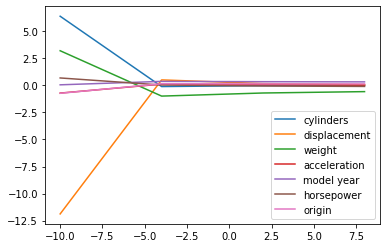

In [50]:
ax= plt.gca()

ax.plot(rdg_data["alpha"],coeffs,label = X_test.columns)
plt.legend()

Text(0.5, 1.0, 'Overfitting and Underfitting')

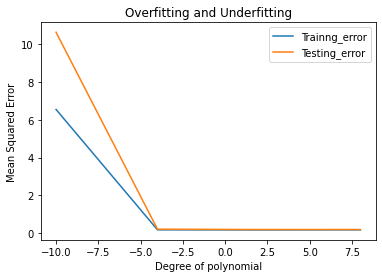

In [52]:
# overfit _ underfit 
plt.plot(lambda_,rdg_data.MSE_train,label="Trainng_error")
plt.plot(lambda_,rdg_data.MSE_test,label="Testing_error")
plt.legend()
plt.xlabel('Degree of polynomial')
plt.ylabel('Mean Squared Error')
plt.title('Overfitting and Underfitting')